# JOSS publication figures creator
This script will create the figures that are used in the JOSS publication of the Metob-toolkit.

In [2]:
import logging
import math
import os
import sys
import time
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import metobs_toolkit


## Creation of the Dataset

In [3]:
datadf = pd.read_csv(metobs_toolkit.demo_datafile, sep=';')
metadf = pd.read_csv(metobs_toolkit.demo_metadatafile, sep=',')

# Subset to regio ghent
ghent_stations = [ 'vlinder24', 'vlinder25', 'vlinder05', 'vlinder27',
                  'vlinder02', 'vlinder01', 'vlinder28']


datadf = datadf[datadf['Vlinder'].isin(ghent_stations)]
metadf = metadf[metadf['Vlinder'].isin(ghent_stations)]

# subset period
datadf['dummy_dt'] = datadf['Datum'] + datadf['Tijd (UTC)']
datadf['dummy_dt'] = pd.to_datetime(datadf['dummy_dt'], format='%Y-%m-%d%H:%M:%S')

#Subset to period
from datetime import datetime
startdt = datetime(2022, 9, 1)
enddt = datetime(2022, 9, 10)
datadf = datadf[(datadf['dummy_dt'] >= startdt) & (datadf['dummy_dt'] <= enddt)]
datadf = datadf.drop(columns=['dummy_dt'])

# Inducing outliers as demo
datadf = datadf.drop(index=datadf.iloc[180:200, :].index.tolist())

# save in paper folder
folder = os.path.abspath('')
datadf.to_csv(os.path.join(folder, 'datafile.csv'))
metadf.to_csv(os.path.join(folder, 'metadatafile.csv'))

#Importing raw data
use_dataset = 'paper_dataset'
dataset = metobs_toolkit.Dataset()
dataset.update_settings(output_folder=folder,
                        input_data_file=os.path.join(folder, 'datafile.csv'),
                        input_metadata_file=os.path.join(folder, 'metadatafile.csv'),
                        template_file=metobs_toolkit.demo_template,
                        )

dataset.import_data_from_file()

## Styling settings

In [4]:
# change color for printing (avoid yellow!)
dataset.settings.app['plot_settings']['color_mapper']['gross_value'] = "#fc0303"

## Timeseries for each station

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:3732: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("datetime")
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:3754: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  self.metadf["dataset_resolution"] = pd.to_timedelta(freq)


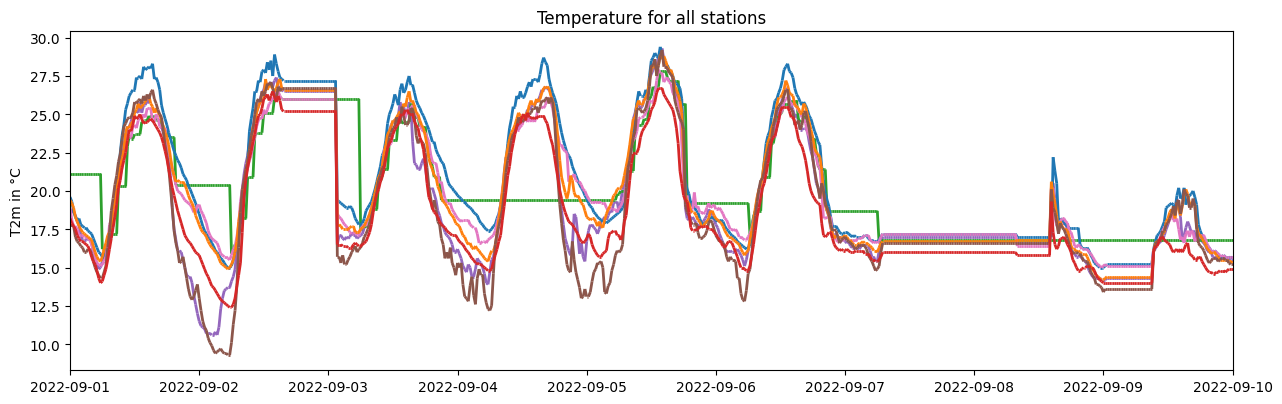

In [5]:
#1. Coarsen resolution and apply quality control with non-defaults as demonstration
dataset.coarsen_time_resolution(freq='20T')

ax1 = dataset.make_plot()

#translate axes
ax1.set_title('Temperature for all stations')
ax1.set_ylabel('T2m in °C')
plt.show()

## Timeseries with quality control labels

buddy radius for the TITAN buddy check updated:  50000--> 10000.0
buddy num min for the TITAN buddy check updated:  2--> 3
buddy threshold for the TITAN buddy check updated:  1.5--> 2.2
buddy min std for the TITAN buddy check updated:  1.0--> 1.0


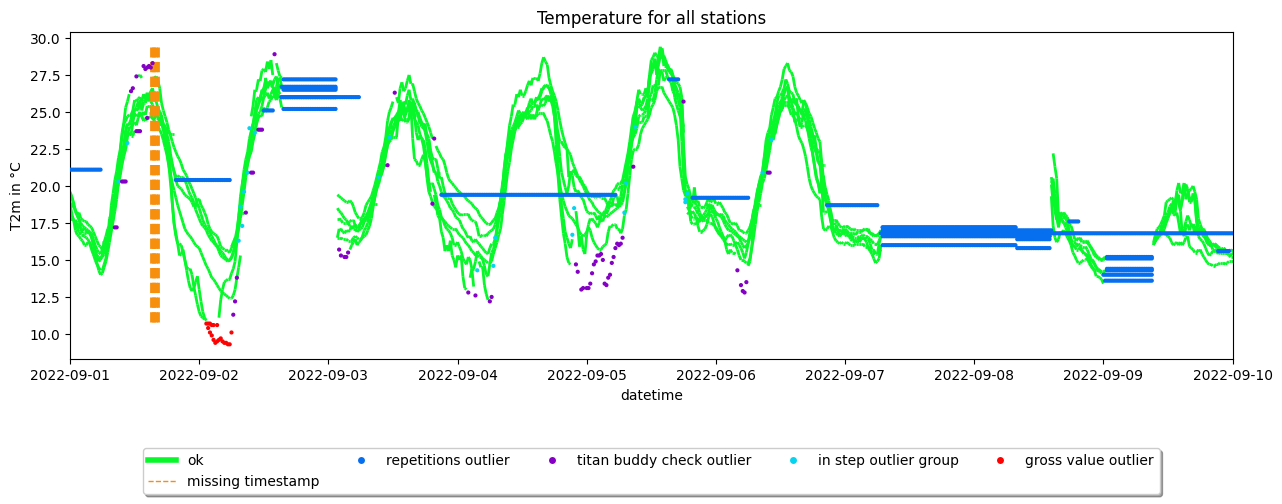

In [6]:
#update QC settings
dataset.update_qc_settings(obstype='temp', gapsize_in_records=None,
                           dupl_timestamp_keep=None,
                           persis_time_win_to_check=None,
                           persis_min_num_obs=None,
                           rep_max_valid_repetitions=None,
                           gross_value_min_value=10.7,
                           gross_value_max_value=None,
                           win_var_max_increase_per_sec=None,
                           win_var_max_decrease_per_sec=None,
                           win_var_time_win_to_check=None,
                           win_var_min_num_obs=None,
                           step_max_increase_per_sec=5./3600.,
                           step_max_decrease_per_sec=None)

dataset.update_titan_qc_settings(obstype='temp', buddy_radius=10000,
                                   buddy_num_min=3, buddy_threshold=2.2,
                                   buddy_max_elev_diff=None,
                                   buddy_elev_gradient=None,
                                   buddy_min_std=1.0,
                                   buddy_num_iterations=None,
                                   buddy_debug=None)

dataset.apply_quality_control()
dataset.apply_titan_buddy_check(use_constant_altitude=True)

# Create the plot
ax2 = dataset.make_plot(colorby='label')
#translate axes
ax2.set_title('Temperature for all stations')
ax2.set_ylabel('T2m in °C')

plt.show()

## Fill gaps and plot timeseries of Vlinder28

(When using the .set_model_from_csv() method, make sure the modelname of your Modeldata is ERA5_hourly)
Modeldata saved in /home/thoverga/Documents/VLINDER_github/MetObs_toolkit/docs/paper/era.pkl


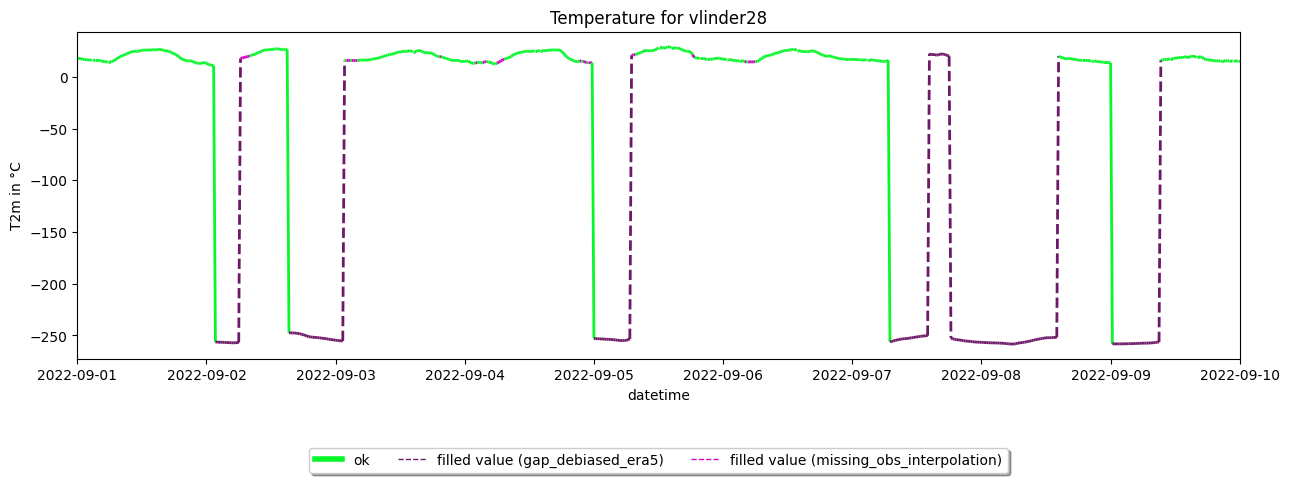

In [7]:
# 1. Update gaps and missing from outliers
dataset.update_gaps_and_missing_from_outliers(obstype='temp', n_gapsize=6)

# 2. update settings
dataset.update_gap_and_missing_fill_settings(gap_interpolation_method=None,
                                             gap_interpolation_max_consec_fill=None,
                                             gap_debias_prefered_leading_period_hours=24,
                                             gap_debias_prefered_trailing_period_hours=4,
                                             gap_debias_minimum_leading_period_hours=24,
                                             gap_debias_minimum_trailing_period_hours=4,
                                             automatic_max_interpolation_duration_str=None,
                                             missing_obs_interpolation_method=None)

# 3. Get modeldata

era5 = dataset.get_modeldata(modelname='ERA5_hourly',
                      modeldata=None, obstype='temp',
                      stations=None, startdt=None, enddt=None)

if not os.path.exists(os.path.join(folder, 'era.pkl')):
    era5.save_modeldata(outputfolder=folder, filename='era.pkl')


dummy_mod = metobs_toolkit.Modeldata('ERA5_hourly')
era5 = dummy_mod.import_modeldata(folder_path=folder,
                                  filename='era.pkl')

# 4. convert units of model
era5.convert_units_to_tlk('temp')

# 5. fill missing obs
dataset.fill_missing_obs_linear()

# 6. fill gaps
dataset.fill_gaps_era5(era5)

# 7. Make plot (of single station for clearity)
ax3 = dataset.get_station('vlinder28').make_plot(colorby='label')

#translate axes
ax3.set_title('Temperature for vlinder28')
ax3.set_ylabel('T2m in °C')

plt.show()


## Diurnal Analysis

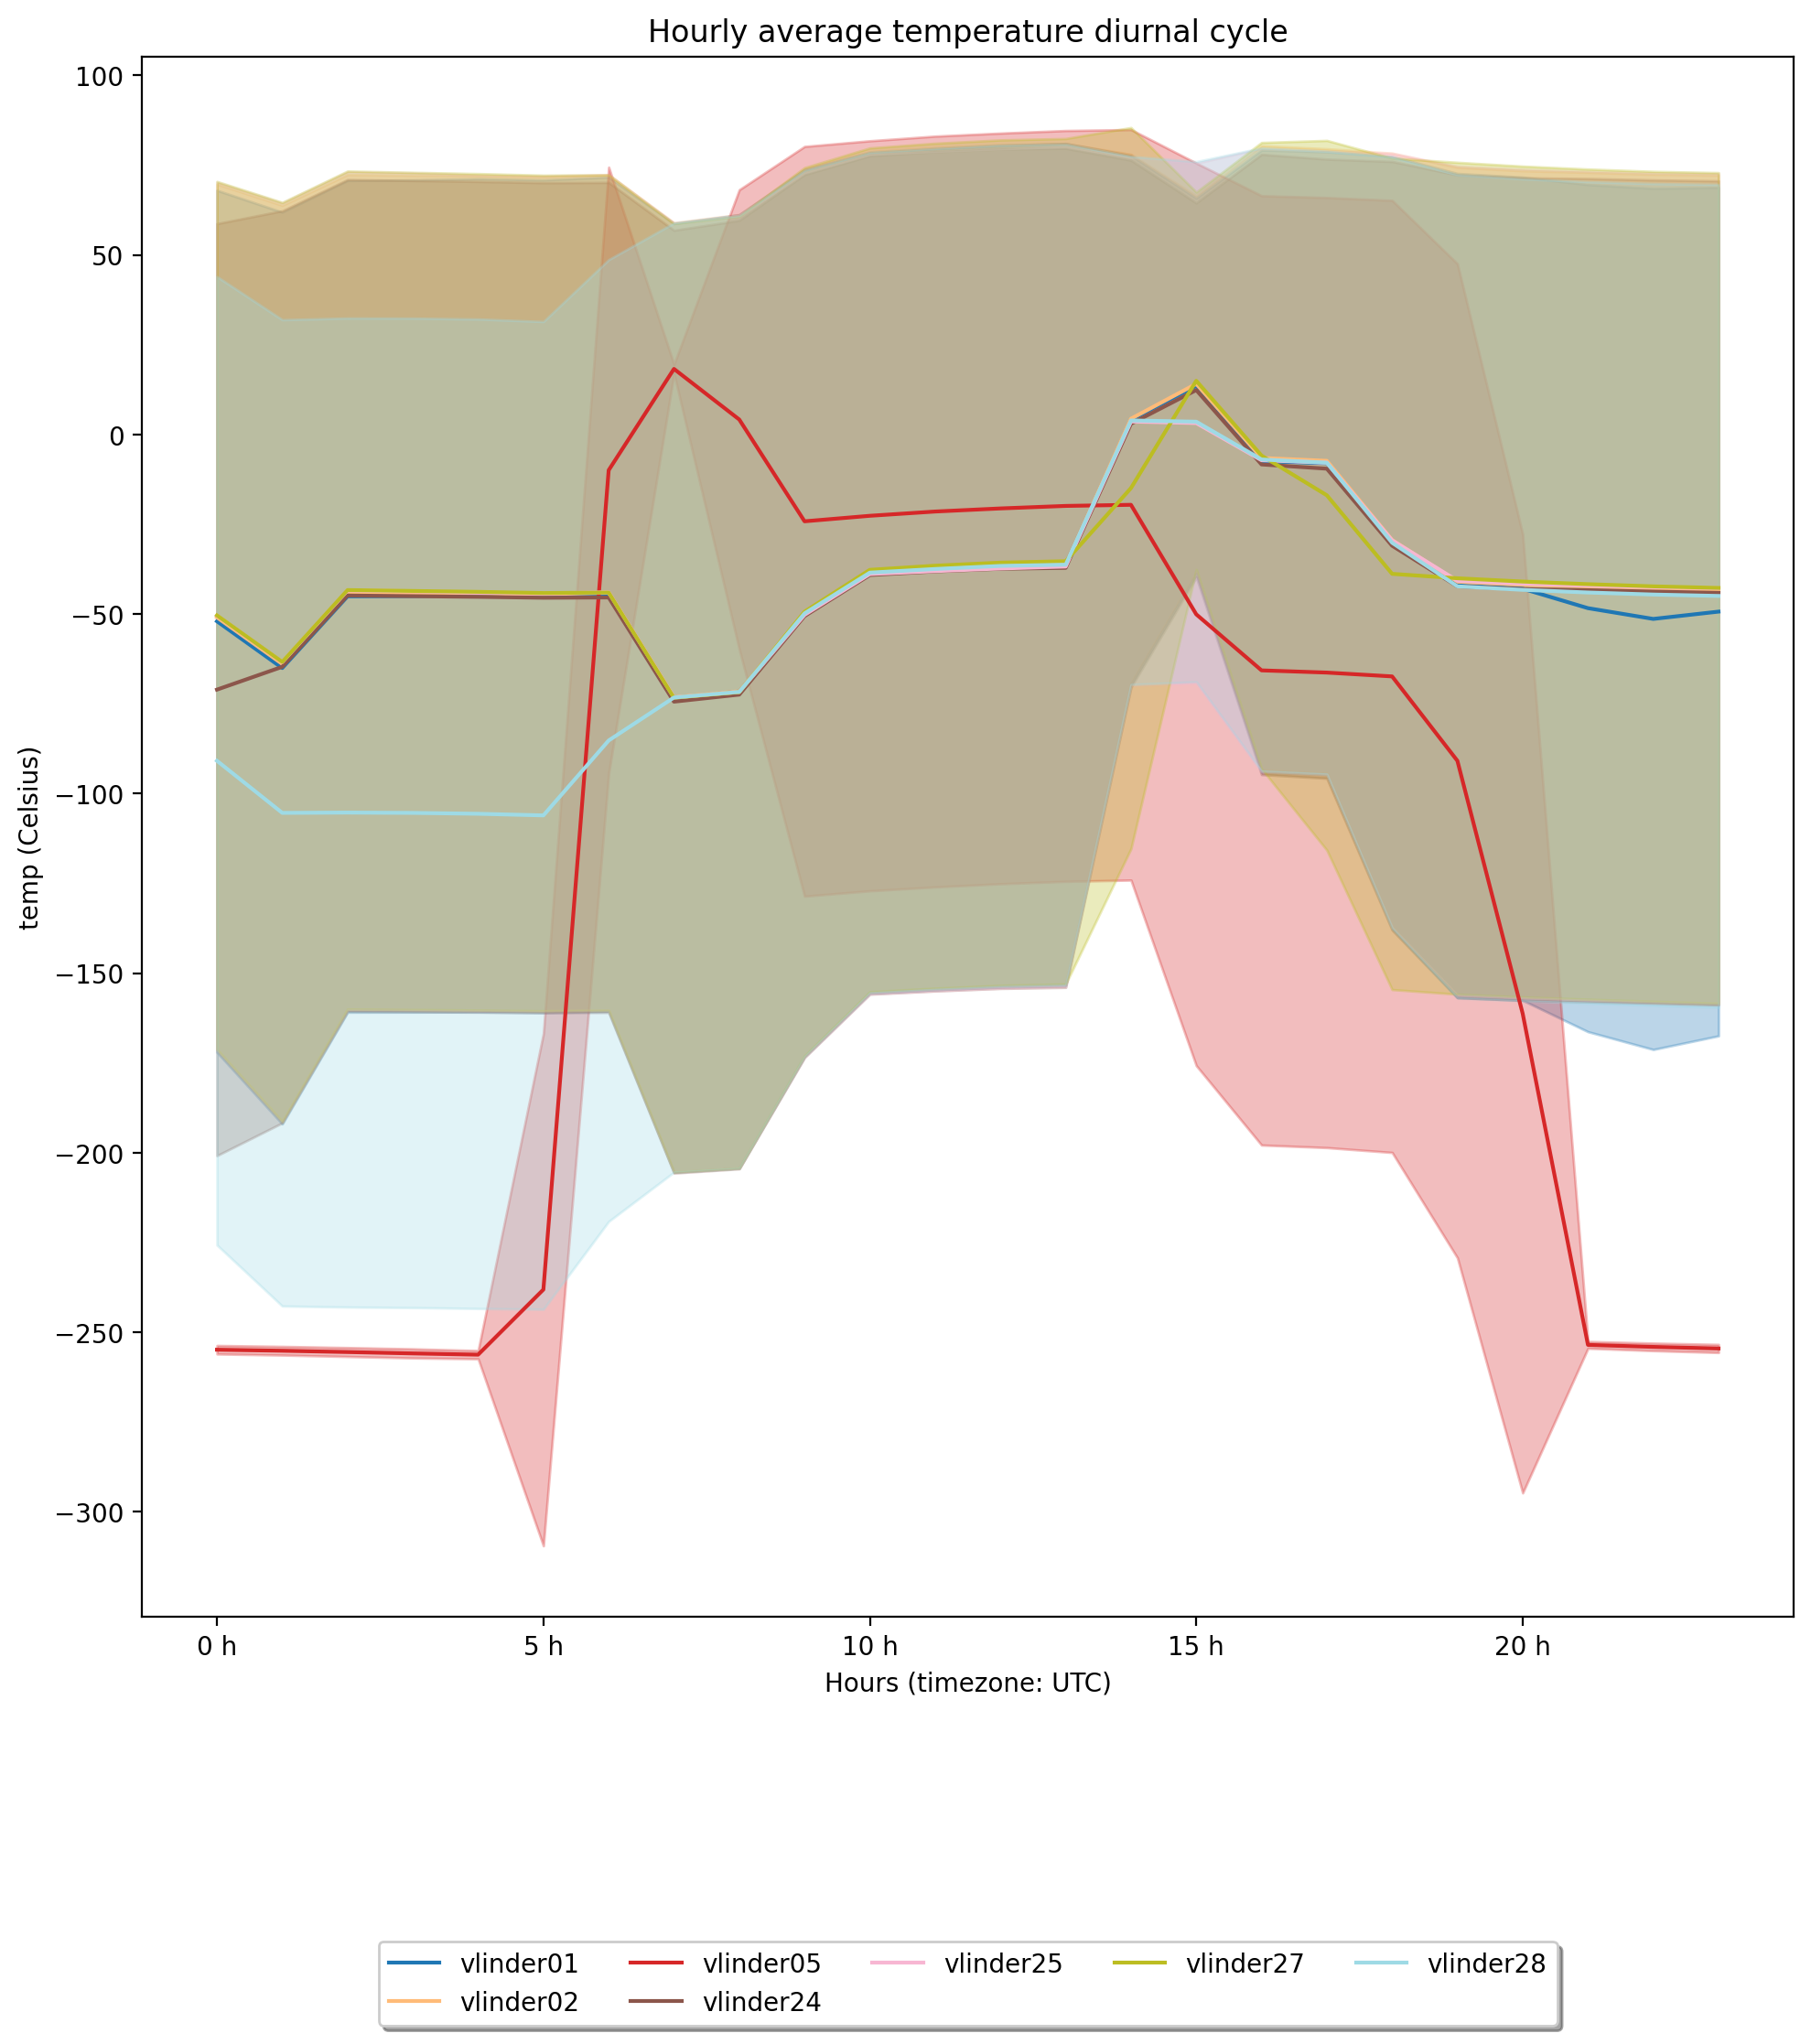

In [8]:

# Get Meta data
dataset.get_landcover(buffers=[50, 150, 500], aggregate=True)
# Create analysis from the dataset
ana = dataset.get_analysis(add_gapfilled_values=True)

# Make diurnal cycle analysis with plot
ax4 = ana.get_diurnal_statistics(colorby='name',
                                 obstype='temp',
                                 stations=None, startdt=None, enddt=None,
                                 plot=True,
                                 title='Hourly average temperature diurnal cycle',
                                 y_label=None, legend=True,
                                 errorbands=True, _return_all_stats=False)

fig = plt.gcf()
fig.set_dpi(200)
fig.tight_layout()

plt.show()

## Interactive spatial

In [9]:
dataset.make_gee_plot(gee_map='worldcover')